<a href="https://colab.research.google.com/github/jimmy-io/Insight_project/blob/master/MODAnet_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Insight/Project/MAsk-RCNN/sample\ images

/content/drive/My Drive/Insight/Project/MAsk-RCNN/sample images


In [10]:
!pip install keras-maskrcnn

In [3]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras
import keras_maskrcnn
import keras_retinanet 

# import keras_retinanet
from keras_maskrcnn import models
from keras_maskrcnn.utils.visualization import draw_mask
from keras_retinanet.utils.visualization import draw_box, draw_caption, draw_annotations
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import json

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [4]:
# adjust this to point to your downloaded/trained model
model_path = os.path.join('/content/drive/My Drive/Insight/Project/MAsk-RCNN', 'resnet50_modanet.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {1: 'bag', 2: 'belt', 3: 'boots', 4: 'footwear', 5: 'outer', 6: 'dress', 7: 'sunglasses', 8: 'pants', 9: 'top', 10: 'shorts', 11: 'skirt', 12: 'headwear', 13: 'scarf/tie'}








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
box_ind is deprecated, use box_indices instead







/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:335: UserWarning: Output "filtered_detections" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "filtered_detections" during training.
  sample_weight_mode=sample_weight_mode)
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:335: UserWarning: Output "mask_submodel" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "mask_submodel" during training.
  sample_weight_mode=sample_weight_mode)
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWar

In [0]:
def cloth_identifier(input_imagefile):
  # load image
  image = read_image_bgr(input_imagefile)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  outputs = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  boxes  = outputs[-4][0]
  scores = outputs[-3][0]
  labels = outputs[-2][0]
  masks  = outputs[-1][0]

  # correct for image scale
  boxes /= scale

  masks_dic={}
  boxes_dic={}
  counter=0

  # visualize detections
  for box, score, label, mask in zip(boxes, scores, labels, masks):
    if score < 0.5:
        break
    

    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    mask = mask[:, :, label]
    draw_mask(draw, b, mask, color=label_color(label))
    
    masks_dic[str(counter)]=mask
    boxes_dic[str(counter)]=box

    counter+=1

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    #draw_caption(draw, b, caption)
    
    newfileneame=input_imagefile.split(".")[0]

  plt.figure(figsize=(15, 15))
  plt.axis('off')
  plt.imshow(draw)
  plt.savefig('masked'+str(newfileneame)+'.jpg',bbox_inches='tight', pad_inches=0)
  plt.show()

  

  return draw, masks_dic, boxes_dic



processing time:  10.328919887542725


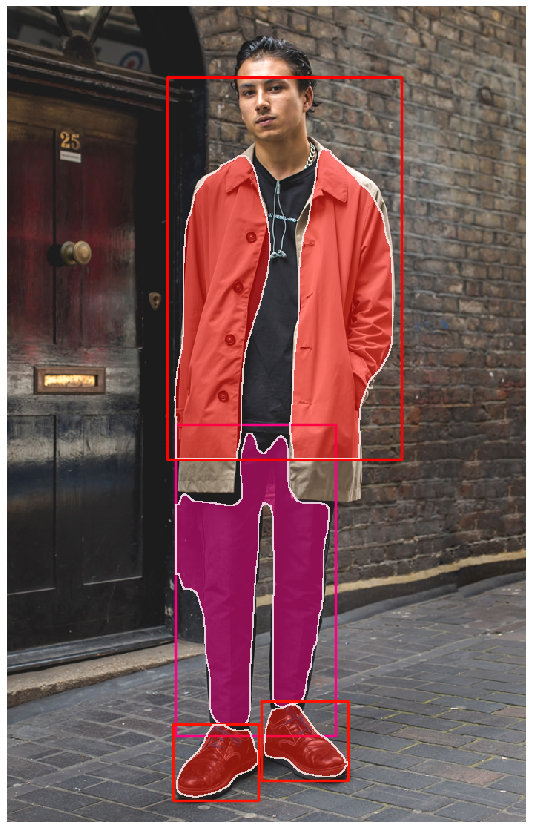

In [128]:
new_img, masks_dic, boxes_dic = cloth_identifier('hannah2019july29.jpg')

In [0]:
### This is the function to extract clothing items separately from an image, given 
### the image and masks and boxes (as dictionaries) extracted using the function 'cloth_identifier'
### and returns a separate image file for each identfied clothing, based on the masks

def cloth_extract(input_imagefile, masks_dic, boxes_dic):
  # load image
  image = read_image_bgr(input_imagefile)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # visualize detections

  items_dic={}
  counter=0

  for box, mask in zip(boxes_dic.values(), masks_dic.values()):

    b = box.astype(int)

    # resize to fit the box
    mask = mask.astype(np.float32)
    mask = cv2.resize(mask, (b[2] - b[0], b[3] - b[1]))

    # binarize the mask
    mask = (mask > 0.5).astype(np.uint8)

    # draw the mask in the image
    mask_image = np.zeros((draw.shape[0], draw.shape[1]), np.uint8)
    mask_image[b[1]:b[3], b[0]:b[2]] = mask
    mask = mask_image

    mask = (np.stack([mask] * 3, axis = 2))*draw

    items_dic[str(counter)] = mask
    counter+=1

    newfileneame=input_imagefile.split(".")[0]

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(mask)
    plt.savefig('masked_item-'+str(counter)+str(newfileneame)+'.jpg',bbox_inches='tight', pad_inches=0)
    plt.show()
  
  return items_dic




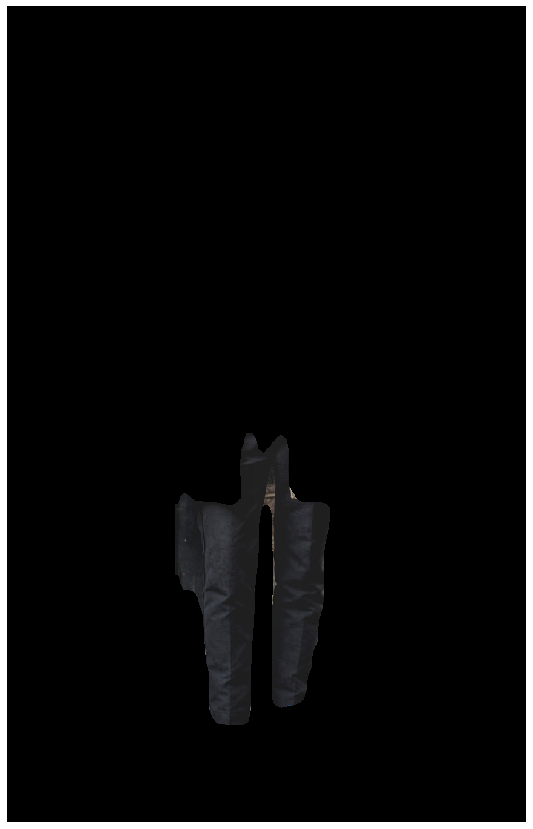

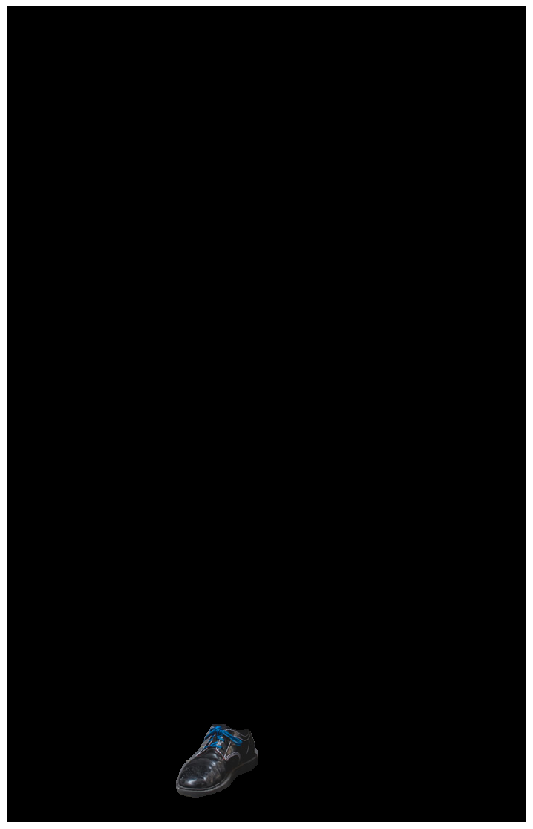

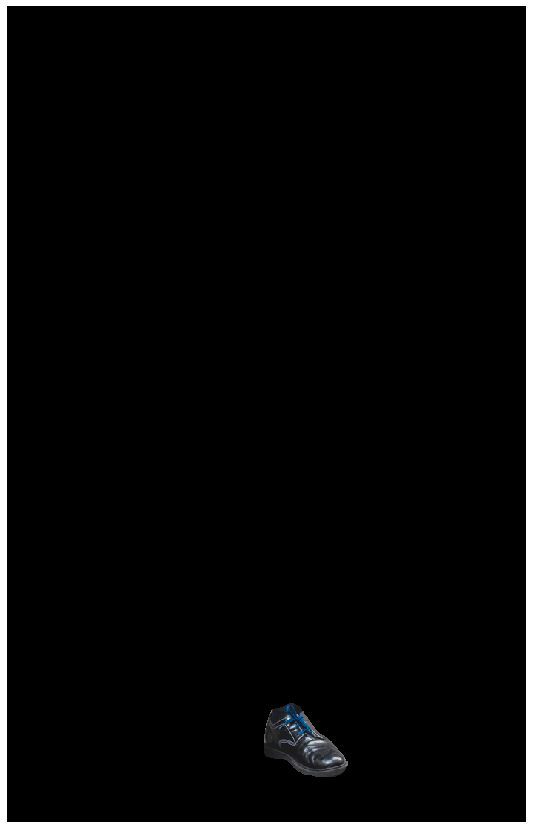

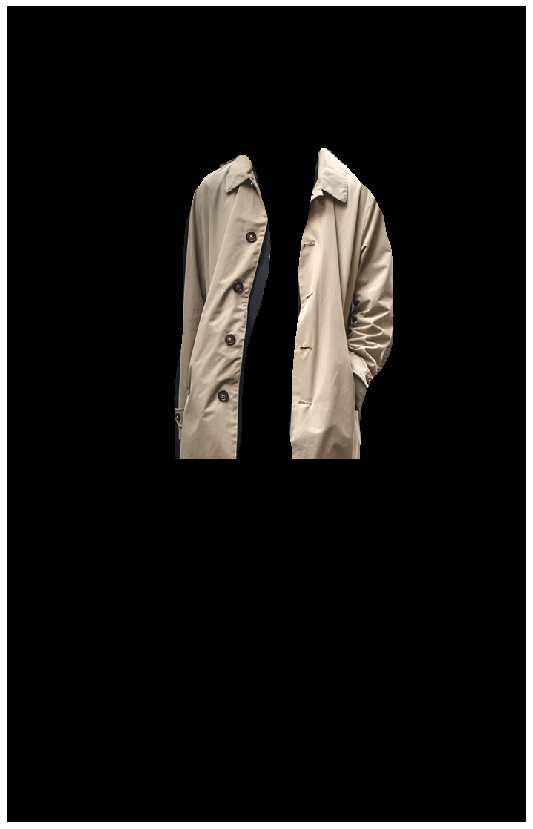

In [135]:
items_dic = cloth_extract('hannah2019july29.jpg', masks_dic, boxes_dic)

processing time:  10.290733814239502


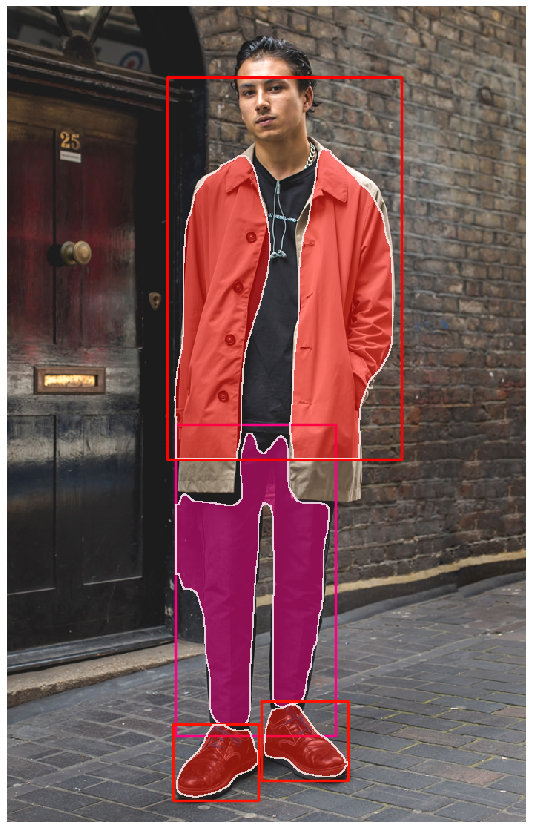

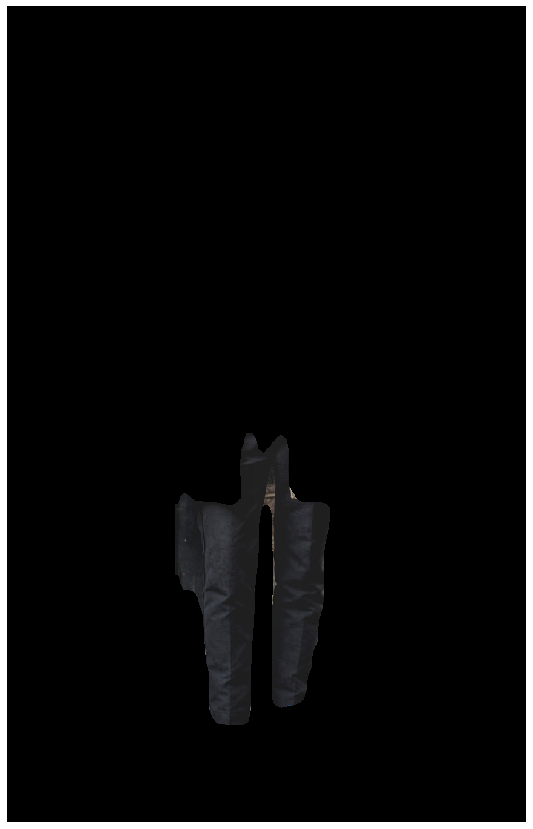

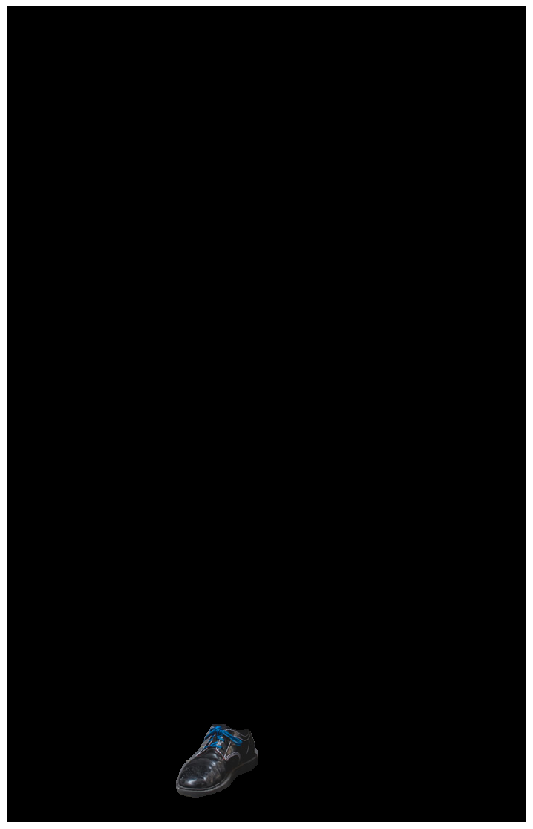

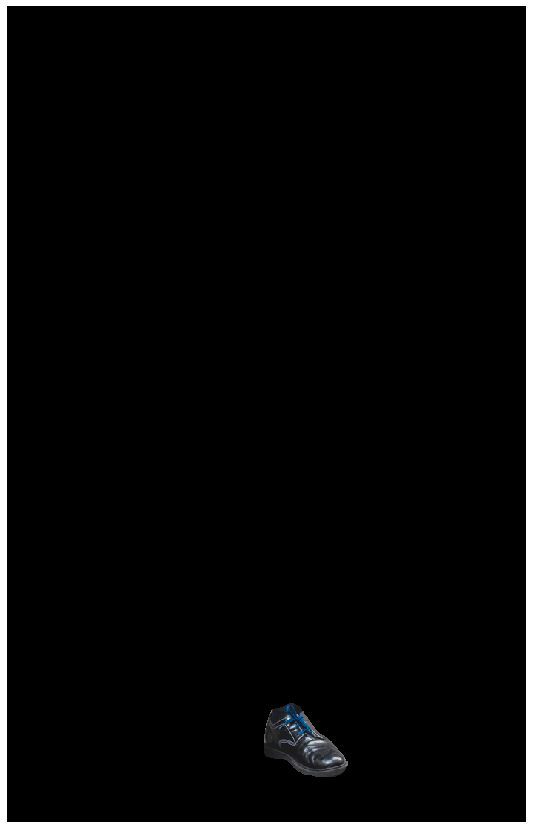

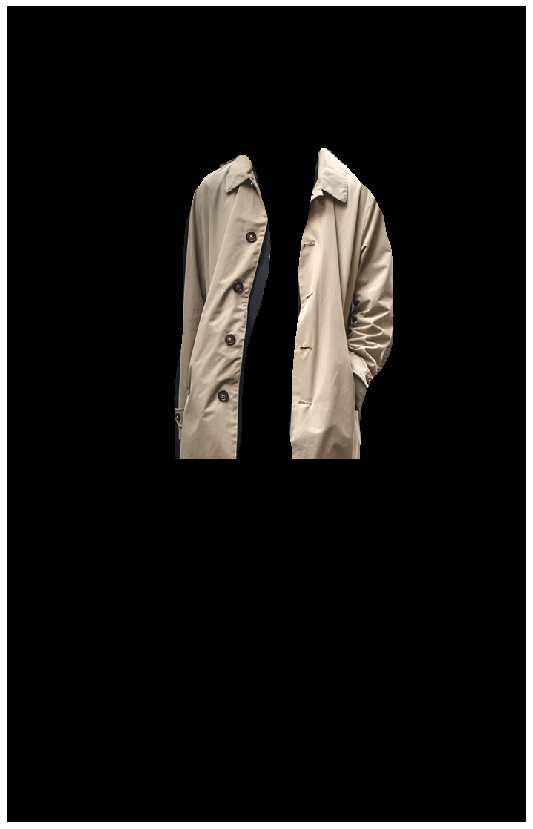

File# 1 of 7 is processed
processing time:  10.243956565856934


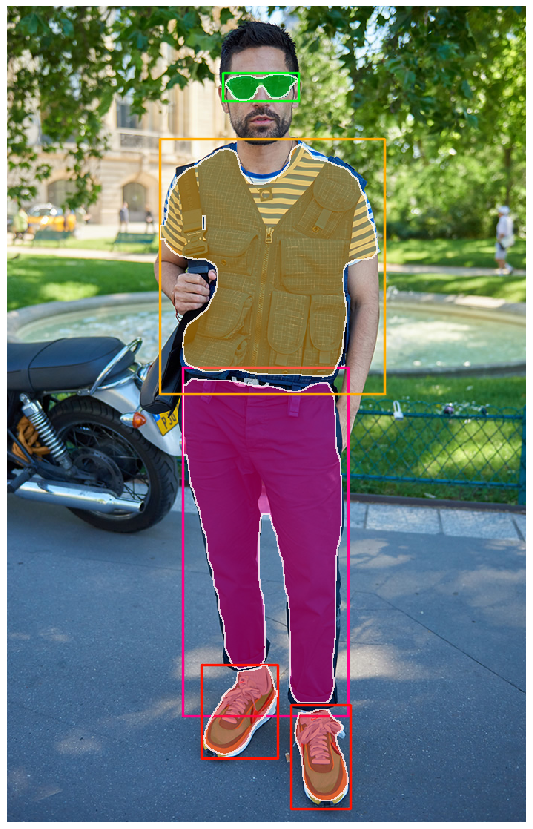

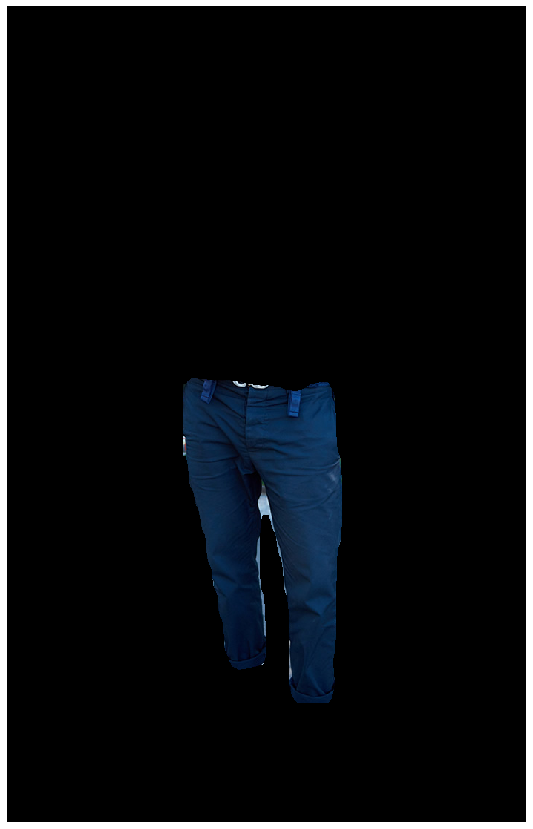

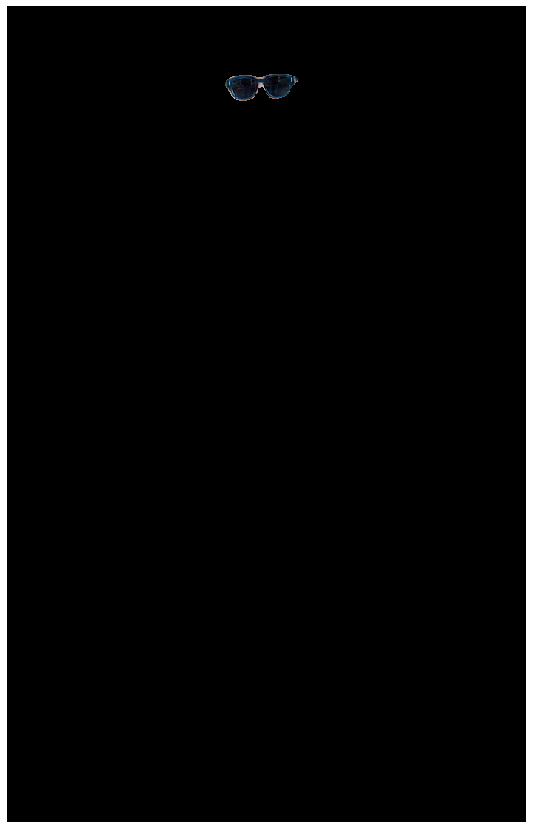

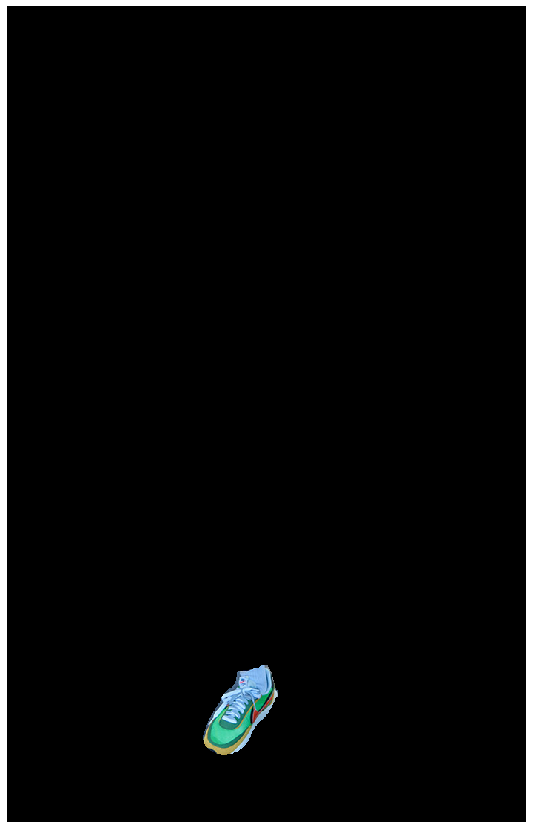

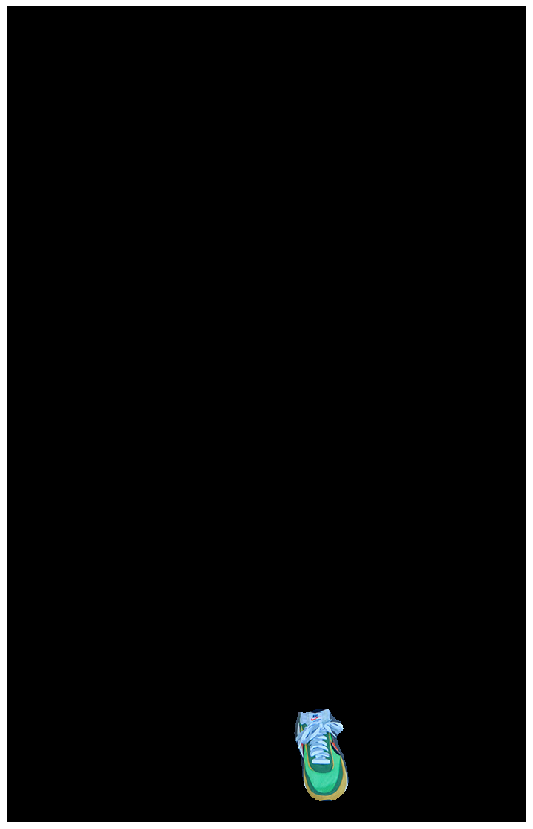

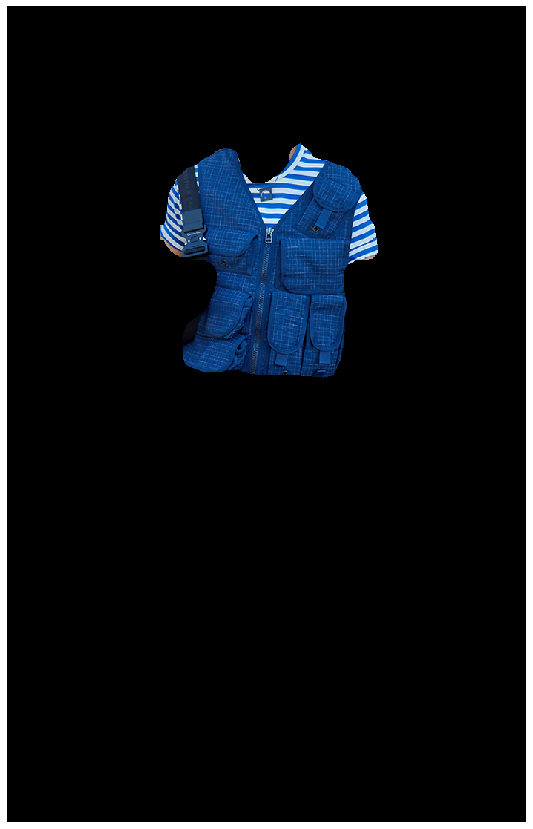

File# 2 of 17 is processed


In [138]:
### To run cloth_identifier and cloth_extract over all images in a directory 

directory = r'/content/drive/My Drive/Insight/Project/MAsk-RCNN/sample images'
counter=0

masked_images_dic={}
masked_items_dic={}

for filename in os.listdir(directory):
 

 new_img, masks_dic, boxes_dic = cloth_identifier(filename)

 items_dic = cloth_extract(filename, masks_dic, boxes_dic)

 key = str(filename)

 masked_images_dic[key]=(new_img)
 masked_items_dic[key]=(items_dic)
 
 counter+=1

 onlyfiles = next(os.walk(directory))[2]

 print("File#",counter,"of",len(onlyfiles),"is processed")

 



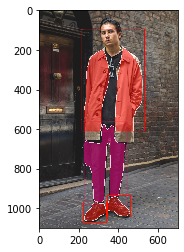

In [113]:
plt.imshow(masked_images_dic['hannah2019july29.jpg'])
plt.savefig('foo.png')

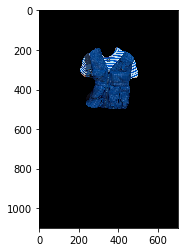

In [94]:
plt.imshow(masked_items_dic['parissstyleimages1.jpg']['4'])
